# Fixed Income Securities - 2023/2024
## Data Science for Finance
### Luís Filipe Ribeiro (nº20231536)

---------------------------------------

We start by defining some common functions that will be useful throughout this notebook...

In [51]:
!pip install quantlib
!pip install jpype1
!pip install tabula-py

import QuantLib as ql
import numpy as np
import pandas as pd

def count_days(d1: ql.Date, d2: ql.Date, basis = ql.Actual360()):
    return basis.dayCount(d1, d2)-1

def count_years(d1: ql.Date, d2: ql.Date, basis = ql.Actual360()):
    return basis.yearFraction(d1, d2)

def get_coupon_dates(issue_date:ql.Date, maturity_date: ql.Date, frequency: int):
    schedule = ql.Schedule(
        issue_date, 
        maturity_date, 
        ql.Period(frequency),
        ql.TARGET(),
        ql.Following,
        ql.Following,
        ql.DateGeneration.Backward, 
        False
    )
    return [dt for dt in schedule][1:]

## a) Build the complete yield curve using interpolation techniques.

In [52]:
from tabula.io import read_pdf

yield_curve_df = read_pdf("project.pdf", pages='5')[0]

# rename columns to actually be useful later on...
yield_curve_df.rename(columns = {"Maturity Date":"maturity", "Market Rate (%)": "rate"}, inplace=True)

#Store valuation date as variable
valuation_date = ql.Date(14,4,2019)

# apply some operations for changhing index and rate (divide by 100 to be used as-is)
yield_curve_df['maturity'] = yield_curve_df['maturity'] \
    .apply(lambda d: pd.to_datetime(d, infer_datetime_format=True)) \
    .apply(lambda d: ql.Date(d.day, d.month, d.year))

yield_curve_df['rate'] = yield_curve_df['rate'].apply(lambda r: r/100)


yield_curve_df['theta'] = yield_curve_df['maturity'] \
    .apply(lambda maturity: count_years(valuation_date, maturity, ql.Thirty360(ql.Thirty360.BondBasis)))


yield_curve_df

C:\Users\rluis\AppData\Local\Temp\ipykernel_10004\1766425719.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  .apply(lambda d: pd.to_datetime(d, infer_datetime_format=True)) \
C:\Users\rluis\AppData\Local\Temp\ipykernel_10004\1766425719.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .apply(lambda d: pd.to_datetime(d, infer_datetime_format=True)) \


,maturity,rate,theta
0,"April 15th, 2019",-0.003640,0.002778
1,"April 23rd, 2019",-0.003780,0.025000
2,"May 16th, 2019",-0.003670,0.088889
3,"July 16th, 2019",-0.003100,0.255556
4,"October 16th, 2019",-0.002320,0.505556
5,"April 16th, 2020",-0.002270,1.005556
6,"October 16th, 2020",-0.001910,1.505556
7,"April 16th, 2021",-0.001992,2.005556
8,"April 19th, 2022",-0.001305,3.013889
9,"April 17th, 2023",-0.000398,4.008333


Now that we have a formatted table. We can use a very simple and readily available method like Cubic Spline to interpolate the yield curve, where the rate is y and theta (maturity versus observation date) is x

In [53]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

#cubic spline the yield curve
yield_curve = CubicSpline(yield_curve_df.theta, yield_curve_df.rate)

#a later useful function to return parallel shifted yield curve receiving shift in bps
def get_shifted_yield_curve(shift_bps):
    shift_pct = shift_bps / 10000 #1 bps = 1/100 % = 1/10000
    return CubicSpline(yield_curve_df.theta, yield_curve_df.rate + shift_pct)

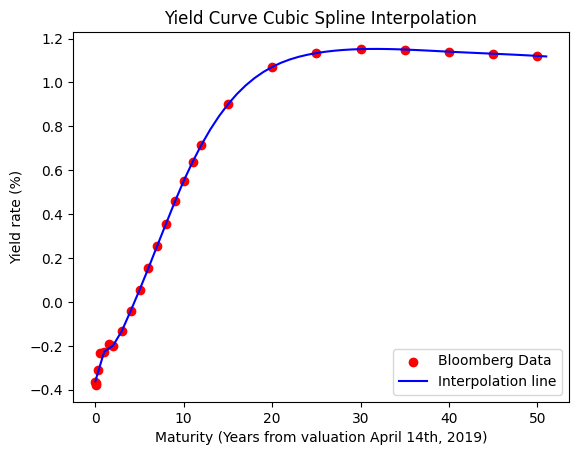

In [54]:
time_axis = np.arange(0, max(yield_curve_df.theta)+1)
rate_axis = yield_curve(time_axis)

plt.scatter(yield_curve_df.theta, yield_curve_df.rate * 100, label='Bloomberg Data', color='red');
plt.plot(time_axis, rate_axis * 100, label='Interpolation line', color='blue');
plt.xlabel(f'Maturity (Years from valuation {valuation_date})')
plt.ylabel('Yield rate (%)')
plt.title('Yield Curve Cubic Spline Interpolation')
plt.legend()
plt.show()

## b) Compute the accrued interest in the fixed and floating legs of the contract.

We assume T+0 lag on settlement date (settlement date = trade date) and notional value of 10 million euros. We can start by defining common vars:

In [55]:
settlement_date = ql.Date(15, 4, 2019)
issue_date = ql.Date(19,1, 2007)
maturity_date = ql.Date(19, 1, 2032)
face_value = 10e6

#swap rate = fixed leg rate
#swap rate != swap par rate
fixed_rate = 0.05982 / 100
float_rate = -0.236 / 100

### Fixed leg

In [56]:
fixed_coupon_dates = [
    date for date in get_coupon_dates(issue_date, maturity_date, 1) 
    if date.year() >= settlement_date.year()
]

print("Coupon dates:\n", pd.Series(fixed_coupon_dates))

#30U/360 basis
fixed_leg_basis = ql.Thirty360(ql.Thirty360.BondBasis)

#Frequency of coupons
fixed_frequency = 1

#Accrued days since last coupon
fixed_ai_u = count_days(fixed_coupon_dates[0], settlement_date, fixed_leg_basis)
fixed_ai_w = 360
print(f"Accrued days since last coupon: {fixed_ai_u}")

#Compute accrued interest (AI)
fixed_ai = fixed_rate/fixed_frequency * fixed_ai_u/fixed_ai_w
print(f"Fixed Leg Accrued Interest: {round(fixed_ai*100, 4)}% of face value or {fixed_ai * face_value} EUR")

Coupon dates:
 0     January 21st, 2019
1     January 20th, 2020
2     January 19th, 2021
3     January 19th, 2022
4     January 19th, 2023
5     January 19th, 2024
6     January 20th, 2025
7     January 19th, 2026
8     January 19th, 2027
9     January 19th, 2028
10    January 19th, 2029
11    January 21st, 2030
12    January 20th, 2031
13    January 19th, 2032
dtype: object
Accrued days since last coupon: 83
Fixed Leg Accrued Interest: 0.0138% of face value or 1379.1833333333336 EUR


### Floating leg

In [57]:
float_coupon_dates = [
    date for date in get_coupon_dates(issue_date, maturity_date, 2) 
    if date.year() >= settlement_date.year()
]

print("Coupon dates:\n", pd.Series(float_coupon_dates))

#30U/360 basis
float_leg_basis = ql.Actual360()

#Frequency of coupons
float_frequency = 2

#Accrued days since last coupon
float_ai_u = count_days(float_coupon_dates[0], settlement_date, float_leg_basis)
float_ai_w = 360/float_frequency
print(f"Accrued days since last coupon: {float_ai_u}")

#Compute accrued interest (AI)
float_ai = np.abs(float_rate)/float_frequency * float_ai_u/float_ai_w
print(f"Float Leg Accrued Interest: {round(float_ai*100, 5)}% of face value or {float_ai * face_value} EUR")

Coupon dates:
 0     January 21st, 2019
1        July 19th, 2019
2     January 20th, 2020
3        July 20th, 2020
4     January 19th, 2021
5        July 19th, 2021
6     January 19th, 2022
7        July 19th, 2022
8     January 19th, 2023
9        July 19th, 2023
10    January 19th, 2024
11       July 19th, 2024
12    January 20th, 2025
13       July 21st, 2025
14    January 19th, 2026
15       July 20th, 2026
16    January 19th, 2027
17       July 19th, 2027
18    January 19th, 2028
19       July 19th, 2028
20    January 19th, 2029
21       July 19th, 2029
22    January 21st, 2030
23       July 19th, 2030
24    January 20th, 2031
25       July 21st, 2031
26    January 19th, 2032
dtype: object
Accrued days since last coupon: 83
Float Leg Accrued Interest: 0.05441% of face value or 5441.1111111111095 EUR


## c) Calculate the clean (principal) and dirty market value of the swap contract

We can start by computing the discount factors which will be the similar for both legs, as well as the coupon dates.

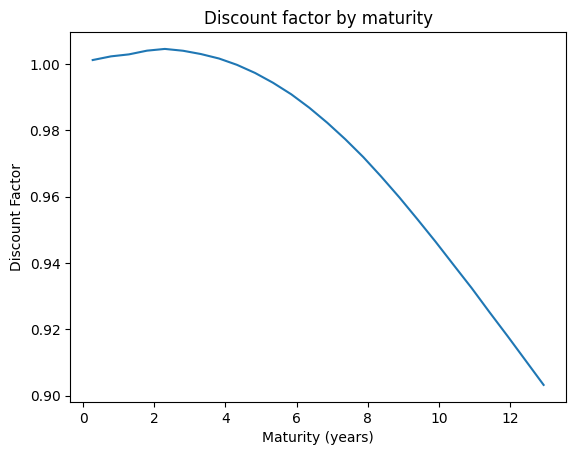

In [58]:
all_coupon_dates = float_coupon_dates[1:]

def get_discount_factors(yield_curve = yield_curve, payment_freq = 1):
    step = 1/float_frequency #since floating has twice as many cashflows
    n_cashflows = len(all_coupon_dates) * step

    #time array / cashflow number
    t = np.arange(step, n_cashflows + step, step)
    r = yield_curve(t)/payment_freq
    return 1/((r + 1) ** t)

def plot_discount_factors(discount_factors):
    plt.figure();
    plt.plot(
        [count_years(settlement_date, d) for d in all_coupon_dates],
        discount_factors
    );
    plt.title('Discount factor by maturity');
    plt.xlabel('Maturity (years)');
    plt.ylabel('Discount Factor');

plot_discount_factors(get_discount_factors(yield_curve))

### Fixed leg

By the formula, we'll start by the first leg - the fixed leg. 
Since the first coupon will be short, we will calculate the short discount:

In [59]:
fixed_short_discount = count_days(settlement_date, fixed_coupon_dates[1], fixed_leg_basis)/360
print(f"We will received {round(fixed_short_discount * 100, 3)}% of the first fixed leg coupon")

We will received 76.111% of the first fixed leg coupon


For the actual bond calculation:

In [60]:
def get_fixed_df(rate = fixed_rate, yield_curve = yield_curve):
    coupon_dates = all_coupon_dates[1::2]
    discount_factors = get_discount_factors(yield_curve)[1::2]
    cashflows = discount_factors * rate * face_value
    
    #specific cases
    cashflows[0] *= fixed_short_discount
    cashflows[-1] += (face_value * discount_factors[-1])

    return pd.DataFrame(data = {
        'discount_factors' : discount_factors,
        'discounted_cashflows': cashflows
    }, index = coupon_dates)
    

fixed_df = get_fixed_df()
fixed_df

,discount_factors,discounted_cashflows
"January 20th, 2020",1.002275,4.563325e+03
"January 19th, 2021",1.003995,6.005899e+03
"January 19th, 2022",1.003967,6.005733e+03
"January 19th, 2023",1.001622,5.991701e+03
"January 19th, 2024",0.997269,5.965664e+03
"January 20th, 2025",0.990828,5.927134e+03
"January 19th, 2026",0.982267,5.875919e+03
"January 19th, 2027",0.971917,5.814010e+03
"January 19th, 2028",0.959781,5.741410e+03
"January 19th, 2029",0.946449,5.661659e+03


We can now compute the prices:

In [61]:
fixed_pv = fixed_df.discounted_cashflows.sum()
fixed_npv = fixed_pv + fixed_ai*face_value

print(f"Fixed Leg PV (Clean): {fixed_pv} EUR or {fixed_pv/face_value * 100}")
print(f"Fixed Leg NPV (Dirty): {fixed_npv} EUR or {fixed_npv/face_value * 100}")

Fixed Leg PV (Clean): 9106667.141241258 EUR or 91.06667141241257
Fixed Leg NPV (Dirty): 9108046.324574592 EUR or 91.08046324574592


### Floating leg

We start by also start by calculating the short discount (which should be the same):

In [62]:
float_short_discount = count_days(settlement_date, fixed_coupon_dates[1], float_leg_basis)/180
print(f"We will received {round(fixed_short_discount * 100, 3)}% of the first fixed leg coupon")

We will received 76.111% of the first fixed leg coupon


We'll have to compute the forward rates:

In [63]:
def get_float_df(yield_curve = yield_curve):
    coupon_dates = all_coupon_dates
    discount_factors = get_discount_factors(yield_curve, 2)

    #compute forwards
    forward_rates = np.ones( len(coupon_dates) )
    for i in range( len(coupon_dates) - 1):
        forward_rates[i+1] = discount_factors[i]/discount_factors[i+1] - 1
    forward_rates[0] = float_rate

    cashflows = discount_factors * forward_rates * face_value
    #specific cases
    cashflows[0] *= fixed_short_discount
    cashflows[-1] += (face_value * discount_factors[-1])

    return pd.DataFrame(data = {
        'discount_factors' : discount_factors,
        'forward_rates': forward_rates,
        'discounted_cashflows': cashflows
    }, index = coupon_dates)
    

float_df = get_float_df(yield_curve)
float_df

,discount_factors,forward_rates,discounted_cashflows
"July 19th, 2019",1.000583,-0.002360,-1.797270e+04
"January 20th, 2020",1.001136,-0.000552,-5.527655e+03
"July 20th, 2020",1.001436,-0.000300,-2.999789e+03
"January 19th, 2021",1.001995,-0.000557,-5.584538e+03
"July 19th, 2021",1.002256,-0.000260,-2.610444e+03
"January 19th, 2022",1.001981,0.000274,2.745552e+03
"July 19th, 2022",1.001486,0.000494,4.951179e+03
"January 19th, 2023",1.000810,0.000675,6.755557e+03
"July 19th, 2023",0.999862,0.000949,9.485002e+03
"January 19th, 2024",0.998633,0.001230,1.228479e+04


Now we can plot the Euribor 6M forward rates:

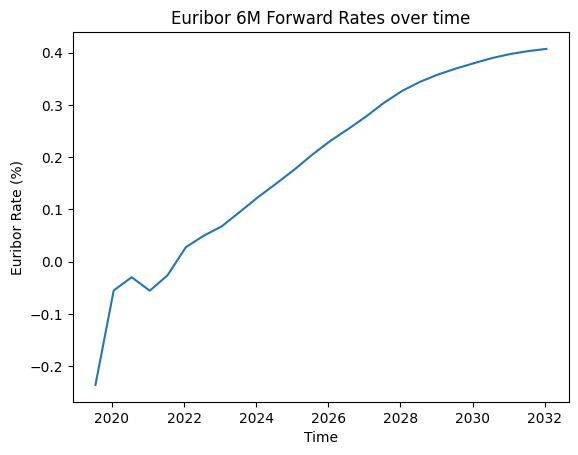

In [64]:
def plot_float_forward_rates(float_df):
    plt.title("Euribor 6M Forward Rates over time");
    plt.plot(
        [pd.Timestamp(dt.year(), dt.month(), dt.dayOfMonth()) for dt in float_df.index],
        float_df['forward_rates'] * 100
    );
    plt.xlabel('Time');
    plt.ylabel('Euribor Rate (%)');

plot_float_forward_rates(float_df)

In [65]:
float_pv = float_df.discounted_cashflows.sum()
float_npv = float_pv + float_ai*face_value

print(f"Float Leg PV (Clean): {float_pv} EUR or {float_pv/face_value * 100}")
print(f"Float Leg NPV (Dirty): {float_npv} EUR or {float_npv/face_value * 100}")

Float Leg PV (Clean): 9987861.610044172 EUR or 99.87861610044172
Float Leg NPV (Dirty): 9993302.721155284 EUR or 99.93302721155284


### Swap market values

In [66]:
def get_swap_clean_dirty_values(swap_rate = fixed_rate, yield_curve=yield_curve):  
    #pvs
    fixed_pv = get_fixed_df(swap_rate, yield_curve).discounted_cashflows.sum()
    float_pv = get_float_df(yield_curve).discounted_cashflows.sum()
    
    #total accrued
    total_accrued = (fixed_ai + float_ai) * face_value

    #values
    swap_clean_value = fixed_pv - float_pv
    swap_dirty_value = swap_clean_value + total_accrued

    return (swap_clean_value, swap_dirty_value)

swap_clean, swap_dirty = get_swap_clean_dirty_values(fixed_rate, yield_curve)
print(f"Swap Clean Price (Principal): {swap_clean} EUR")
print(f"Swap Dirty Price (NPV): {swap_dirty} EUR")

Swap Clean Price (Principal): -881194.468802914 EUR
Swap Dirty Price (NPV): -874374.1743584696 EUR


## d) Estimate the net present value of the contract

The Net Present Value of the contract is simply the dirty market value of the swap, which includes both accrued interests.

In [67]:
print(f"Swap NPV: {get_swap_clean_dirty_values(fixed_rate, yield_curve)[1]} EUR")

Swap NPV: -874374.1743584696 EUR


## e) Estimate the swap par rate

We can do it computationally, passing the swap value function as a paremeter with initial guess of fixed rate until we reach zero:

In [68]:
from scipy.optimize import fsolve

swap_par_rate = fsolve(lambda r: get_swap_clean_dirty_values(r)[0], fixed_rate)[0]

print(f"If swap par rate is {swap_par_rate*100}% then Swap value = {get_swap_clean_dirty_values(swap_par_rate)[0]}")

If swap par rate is 0.7719210345459566% then Swap value = 0.0


Graphically we can deduce the solution as well:

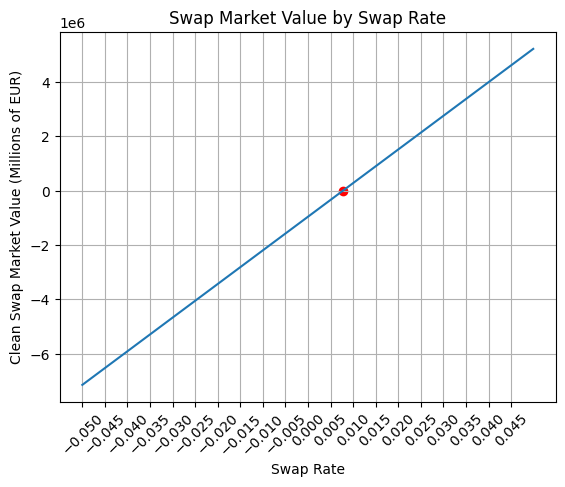

In [69]:
plt.title("Swap Market Value by Swap Rate");
plt.plot(
    np.arange(-0.05,0.05,1/10000), 
    np.array([get_swap_clean_dirty_values(r)[0] for r in np.arange(-0.05,0.05,1/10000)])
);
plt.scatter([swap_par_rate], [get_swap_clean_dirty_values(swap_par_rate)[0]], color='red');
plt.xlabel('Swap Rate');
plt.ylabel('Clean Swap Market Value (Millions of EUR)');
plt.xticks(np.arange(-0.05,0.05, 0.005), rotation=45);
plt.grid(True);

## f) Estimate the following IRS Greeks: present value of a one basis point shift (PV01), DV01, Gamma and discuss the interest rate risk of the contract

We can start to see what happens with various shifts in yield curve:

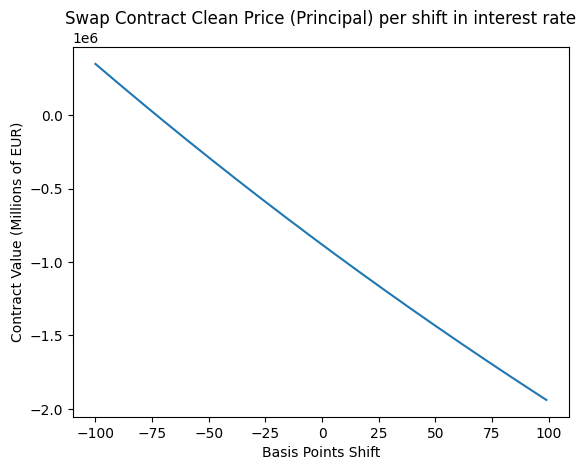

In [70]:
plt.figure();
plt.plot(
    np.arange(-100, 100, 1),
    [
        get_swap_clean_dirty_values(fixed_rate, get_shifted_yield_curve(bps_shift))[0] 
        for bps_shift in np.arange(-100, 100, 1)
    ]
);
plt.title("Swap Contract Clean Price (Principal) per shift in interest rate");
plt.xlabel("Basis Points Shift");
plt.ylabel("Contract Value (Millions of EUR)");

This validates the literature since we can see because of our float short position (receiving fixed), we profit off of interest rate down-shifts and lose money on up-shifts since the floating leg will be more valuable.

### PV01 - Simple interest rate hike shock

In [71]:
def get_pv01():
    p = get_swap_clean_dirty_values(fixed_rate, yield_curve)[0]
    p_new = get_swap_clean_dirty_values(fixed_rate, get_shifted_yield_curve(1))[0]
    return p-p_new

get_pv01()

11444.318733830005

### DV01 - Dollar Value Change

In [72]:
def get_dv01():
    #similar to bloomberg calculations
    p_up = get_swap_clean_dirty_values(fixed_rate, get_shifted_yield_curve(1))[0]
    p = get_swap_clean_dirty_values(fixed_rate, yield_curve)[0]
    p_down = get_swap_clean_dirty_values(fixed_rate, get_shifted_yield_curve(-1))[0]
    return (p_down-p_up)/2

get_dv01()

11452.42677406501

### Gamma (Convexity)

In [73]:
def get_gamma():
    p_up = get_swap_clean_dirty_values(fixed_rate, get_shifted_yield_curve(1))[0]
    p = get_swap_clean_dirty_values(fixed_rate, yield_curve)[0]
    p_down = get_swap_clean_dirty_values(fixed_rate, get_shifted_yield_curve(-1))[0]
    return (p_up - 2 * p + p_down)

get_gamma()

16.21608047001064

-------------------------------
## Used sources

1. https://finpricing.com/lib/IrSwap.html
2. https://www.youtube.com/watch?v=DrlKjSG1V6s&ab_channel=RyanO%27Connell%2CCFA%2CFRM
3. https://insight.factset.com/hubfs/Resources/White%20Papers/Interest_Rate_Swap_Valuation_WP.pdf
4. https://analystprep.com/cfa-level-1-exam/fixed-income/modified-duration-money-duration-and-price-value-of-a-basis-point-pvbp/
5. https://www.pearsonhighered.com/assets/samplechapter/0/1/3/1/0131962590.pdf
6. https://www.wallstreetoasis.com/forum/trading/questions-about-the-dv01-and-duration-of-interest-rate-swap